In [2]:

import mne
import numpy as np
from scipy.signal import hilbert
from mne_connectivity import spectral_connectivity_time
from scipy.io import loadmat
import pandas as pd
import os
rng = np.random.default_rng(42)  # set seed for reproducibility

In [4]:
# Define the folder where the subject-specific CSV files are stored
data_folder = r"W:\Projects\2019-04 M1M1PAS Project\analysis\source_Paolo\BeamformeroldLF"

# Get a list of all the CSV files for the subjects
file_list = [f for f in os.listdir(data_folder)]

# Initialize an empty list to store DataFrames
datapd = []
data = []

# Loop through each file and import the DataFrame
for file in file_list:
    # file = file_list[0]

    subject = file.split('_')[0].replace('sub-', '')
    task = file.split('_')[1].replace('task-', '')
    run = file.split('_')[2].replace('run-', '')

    file_path = os.path.join(data_folder, file)

    matlabdata = loadmat(file_path)

    leftSM = matlabdata['leftSM']
    rightSM = matlabdata['rightSM']

    # Create a new MNE RawArray with the raw data
    info = mne.create_info(ch_names=['leftSM', 'rightSM'], sfreq=1000, ch_types='eeg')

    source_data = np.vstack([leftSM, rightSM])

    source_raw = mne.io.RawArray(source_data, info)

    source_raw.resample(sfreq=200)

    # Epoch data
    epochs_raw = mne.make_fixed_length_epochs(source_raw, duration=2, preload=True)

    sfreq = epochs_raw.info['sfreq']
    # Define the frequency band for the analysis (Alpha: 8-13 Hz)
    fmin, fmax = 8., 13.
    freqs = np.linspace(fmin, fmax, int((fmax - fmin) * 1 + 1))

    # Calculate connectivity
    con = spectral_connectivity_time(
    epochs_raw,
    method=['wpli'],
    #sfreq=sfreq,
    freqs=freqs,
    #fmin=fmin,
    #fmax=fmax,
    faverage=True,  # Average connectivity across frequencies within the band
    mode='cwt_morlet',  # Use multitaper method,
    n_cycles = 5,
    average=False,
    n_jobs=1  # Number of parallel jobs to run (set according to your CPU)
    )
    fc = con.get_data()[:,2,0]

    # Find the median PLV across all windows
    threshold_fc = np.percentile(fc, 75)

    # Select windows where PLV > median PLV
    high_fc_windows = fc > threshold_fc

    # Band-pass filter between 8 and 13 Hz (alpha band)
    raw_filtered = source_raw.copy().filter(l_freq=fmin, h_freq=fmax)
    
    raw_filtered_resampled = raw_filtered.resample(sfreq=50)

    raw_analytic = raw_filtered_resampled.copy().apply_hilbert()

    # Epoch data
    epochs_analytic = mne.make_fixed_length_epochs(raw_analytic, duration=2, preload=True)

    # Get data for right
    rightSM_analytic = epochs_analytic.get_data(picks='rightSM')
    # Get data for left
    leftSM_analytic = epochs_analytic.get_data(picks='leftSM')

    rightSM_analytic = np.squeeze(rightSM_analytic)
    leftSM_analytic = np.squeeze(leftSM_analytic)

    # Compute signal envelopes using Hilbert transform
    rightSM_envelope = np.abs(rightSM_analytic)
    leftSM_envelope = np.abs(leftSM_analytic)

    # Calculate the medians of the envelopes
    right_median_win = np.median(rightSM_envelope, axis = 1)
    left_median_win = np.median(leftSM_envelope, axis = 1)

    # Calculate the medians of the envelopes
    right_threshold = np.percentile(right_median_win, 50)
    left_threshold = np.percentile(left_median_win, 50)

    # Select the lower median as the threshold median
    threshold_env = min(right_threshold, left_threshold)

    # Select windows where the envelope median exceeds the threshold
    high_env_windows = np.logical_and(left_median_win > threshold_env, right_median_win > threshold_env)

    selected_windows = np.logical_and(high_env_windows,high_fc_windows)

    right_analytic_selected = rightSM_analytic[selected_windows,:]
    left_analytic_selected = leftSM_analytic[selected_windows,:]

    right_analytic_selected_cat = np.concatenate(right_analytic_selected,axis=0)
    left_analytic_selected_cat = np.concatenate(left_analytic_selected,axis=0)

    # Extract phases
    right_phase = np.angle(right_analytic_selected_cat)
    left_phase = np.angle(left_analytic_selected_cat)

    # Calculate phase lags between C3 and C4
    phase_lags = np.unwrap(right_phase - left_phase)

    # # Collect the data
    data.extend([(subject, task, run, phase_lag) for phase_lag in phase_lags])

    # # Convert the list to a dataframe
    datapd = pd.DataFrame(phase_lags, columns=['phase_lag'])

    # Save PLV and wPLI arrays in a single .npz file
    new_filename = f"{file.replace('_Beam.mat', '')}_phlags.csv"
    new_file_path = os.path.join(r"W:\Projects\2019-04 M1M1PAS Project\analysis\source_Paolo\fc_source\BeamformeroldLFtest",new_filename)
    datapd.to_csv(new_file_path)
    
# # # Convert the list to a dataframe
# datapd = pd.DataFrame(data, columns=['subject','task', 'run', 'phase_lag'])

# # Save PLV and wPLI arrays in a single .npz file
# new_filename = f"sourceBeamformeroldLF_phlags.csv"
# new_file_path = os.path.join(r"W:\Projects\2019-04 M1M1PAS Project\analysis\source_Paolo\fc_source",new_filename)
# datapd.to_csv(new_file_path)


Creating RawArray with float64 data, n_channels=2, n_times=299001
    Range : 0 ... 299000 =      0.000 ...   299.000 secs
Ready.
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 400 original time points ...
0 bad epochs dropped
Adding metadata with 3 columns
Fmin was not specified. Using fmin=min(freqs)
Fmax was not specified. Using fmax=max(freqs).
only using indices for lower-triangular matrix
Connectivity computation...
   Processing epoch 1 / 149 ...
   Processing epoch 2 / 149 ...
   Processing epoch 3 / 149 ...
   Processing epoch 4 / 149 ...
   Processing epoch 5 / 149 ...
   Processing epoch 6 / 149 ...
   Processing epoch 7 / 149 ...
   Processing epoch 8 / 149 ...
   Processing epoch 9 / 149 ...
   Processing epoch 10 / 149 ...
   Processing epoch 11 / 149 ...
   Processing epoch 12 / 149 ...
   Processing epoch 13 / 149 ...
   Processing epoch 14 / 149 ...
   Processin

In [15]:
datapd

,subject,task,run,phase_lag
0,11,negneg,1,-1.147513
1,11,negneg,1,-0.728812
2,11,negneg,1,-0.418661
3,11,negneg,1,-0.201326
4,11,negneg,1,-0.052545
...,...,...,...,...
1116995,9,random,5,58.212319
1116996,9,random,5,58.288012
1116997,9,random,5,58.160780
1116998,9,random,5,57.940350


In [3]:
new_filename

'sub-11_task-random_run-2_phlags.csv'

Text(0.5, 1.0, 'Raw')

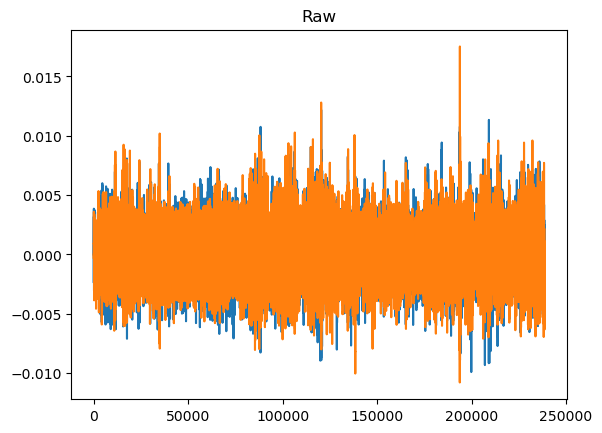

In [4]:
import matplotlib.pyplot as plt
plt.plot(np.squeeze(leftSM[0:1000]))
plt.plot(np.squeeze(rightSM[0:1000]))
plt.title('Raw')

Text(0.5, 1.0, 'Downsampled')

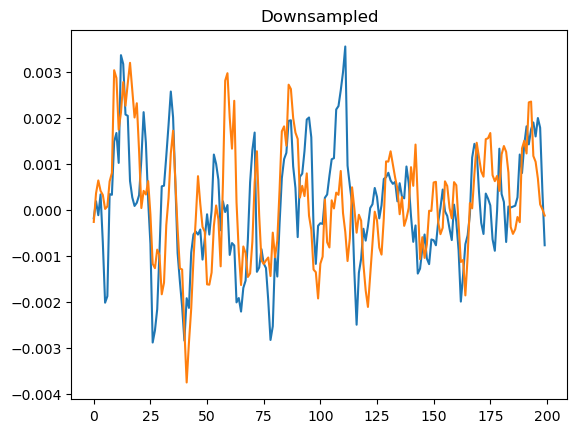

In [5]:
left_resampled = source_raw.get_data(picks='leftSM')
right_resampled = source_raw.get_data(picks='rightSM')
plt.plot(np.squeeze(left_resampled[:,0:200]))
plt.plot(np.squeeze(right_resampled[:,0:200]))
plt.title('Downsampled')

Text(0.5, 1.0, 'BP-filtered')

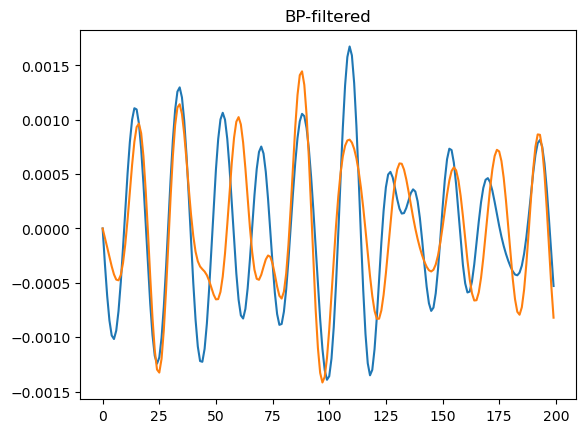

In [6]:
left_filtered = raw_filtered.get_data(picks='leftSM')
right_filtered = raw_filtered.get_data(picks='rightSM')
plt.plot(np.squeeze(left_filtered[:,0:200]))
plt.plot(np.squeeze(right_filtered[:,0:200]))
plt.title('BP-filtered')

Text(0.5, 1.0, 'Hilberted')

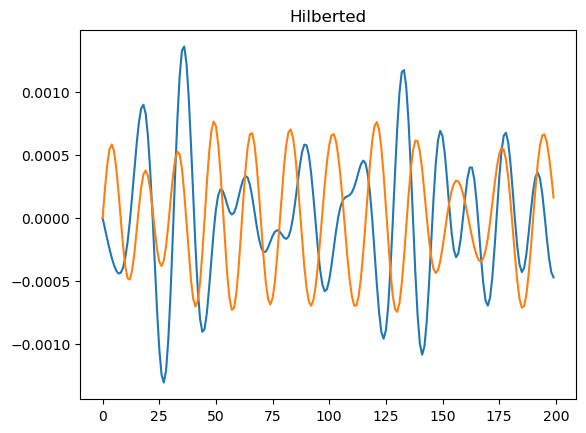

In [8]:
plt.plot(np.squeeze(np.real(leftSM_analytic[0,:])))
plt.plot(np.squeeze(np.real(rightSM_analytic[0,:])))
plt.title('Hilberted')

Text(0.5, 1.0, 'Phases and phase lag')

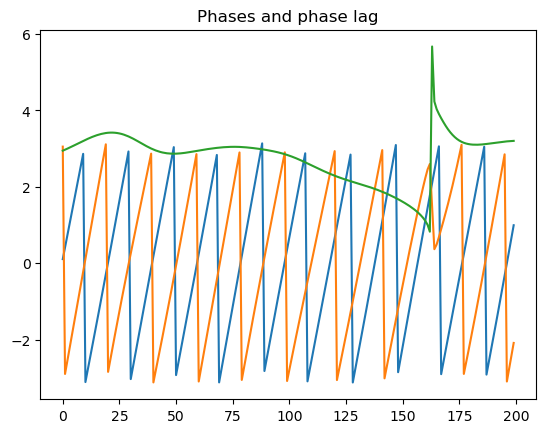

In [6]:
phase_lags_normalized = phase_lags % (2 * np.pi)
plt.plot(np.squeeze(left_phase[0:200]))
plt.plot(np.squeeze(right_phase[0:200]))
plt.plot(np.squeeze(phase_lags_normalized[0:200]))
plt.title('Phases and phase lag')

(array([2956., 1798.,  597.,  337.,  277.,  307.,  308.,  543., 1372.,
        1905.]),
 array([1.64857729e-04, 6.28466840e-01, 1.25676882e+00, 1.88507081e+00,
        2.51337279e+00, 3.14167477e+00, 3.76997675e+00, 4.39827874e+00,
        5.02658072e+00, 5.65488270e+00, 6.28318468e+00]),
 <BarContainer object of 10 artists>)

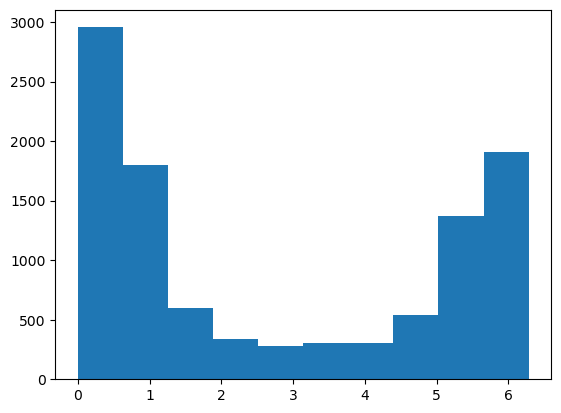

In [7]:
phase_lags_normalized = phase_lags % (2 * np.pi)
plt.hist(phase_lags_normalized)

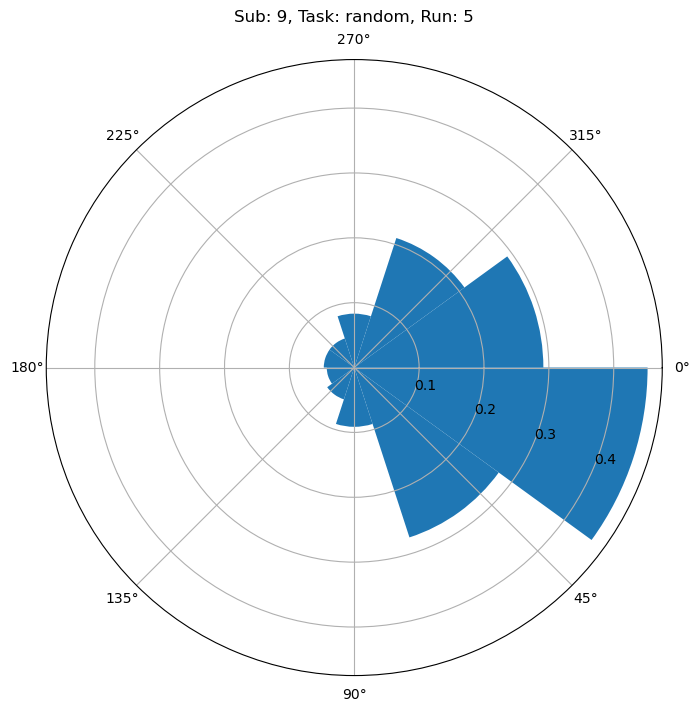

In [8]:
n_bins = 10

fig, axes = plt.subplots(1, 1, subplot_kw={'polar': True}, figsize=(12, 8))

# Normalize phase lags to be between 0 and 2*pi
phase_lag_normalized = phase_lags % (2 * np.pi)

# Compute the histogram
counts, bin_edges = np.histogram(phase_lag_normalized, bins=n_bins, range=(0, 2 * np.pi), density=True)

# Convert bin edges to bin centers for polar plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
width = bin_edges[1] - bin_edges[0]  # Calculate the width

# Plot the histogram in the current subplot
ax = axes
ax.bar(bin_centers, counts, width=width, align='center')

# Set title and labels
ax.set_title(f'Sub: {subject}, Task: {task}, Run: {run}', va='bottom')
ax.set_theta_zero_location('E')  # Set 0 radians (north) on the top
ax.set_theta_direction(-1)  # Set the direction of theta to go clockwise

# Compute the circular mean
# circular_mean = stats.circmean(phase_lag_normalized, high=2*np.pi, low=0)

# Plot the median line
# ax.plot([circular_mean, circular_mean], [0, max(counts)], color='red', linewidth=1)

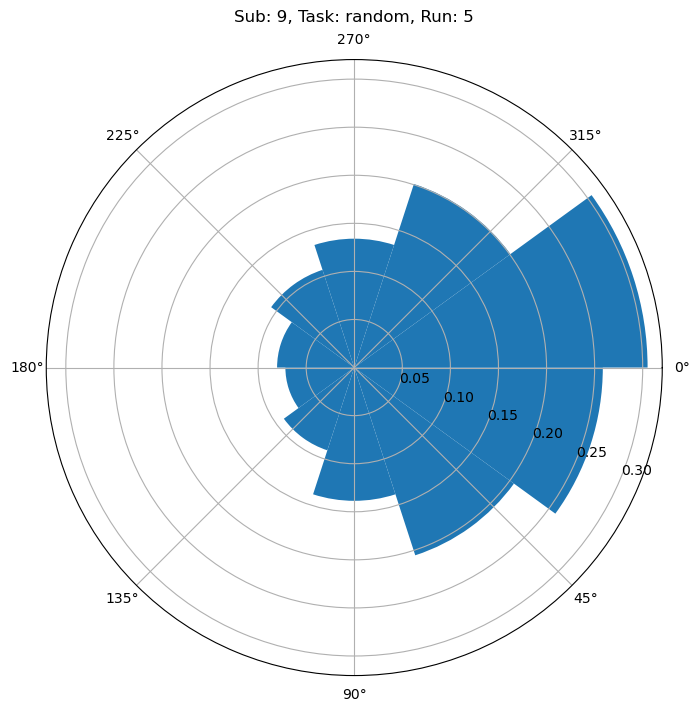

In [15]:
n_bins = 10

fig, axes = plt.subplots(1, 1, subplot_kw={'polar': True}, figsize=(12, 8))

# Normalize phase lags to be between 0 and 2*pi
phase_lag_normalized = phase_lags % (2 * np.pi)

# Compute the histogram
counts, bin_edges = np.histogram(phase_lag_normalized, bins=n_bins, range=(0, 2 * np.pi), density=True)

# Convert bin edges to bin centers for polar plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
width = bin_edges[1] - bin_edges[0]  # Calculate the width

# Plot the histogram in the current subplot
ax = axes
ax.bar(bin_centers, counts, width=width, align='center')

# Set title and labels
ax.set_title(f'Sub: {subject}, Task: {task}, Run: {run}', va='bottom')
ax.set_theta_zero_location('E')  # Set 0 radians (north) on the top
ax.set_theta_direction(-1)  # Set the direction of theta to go clockwise

# Compute the circular mean
# circular_mean = stats.circmean(phase_lag_normalized, high=2*np.pi, low=0)

# Plot the median line
# ax.plot([circular_mean, circular_mean], [0, max(counts)], color='red', linewidth=1)